In [0]:
%matplotlib inline

In [0]:
import torchvision.models as models
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import numpy as np
from PIL import Image
import copy
import matplotlib.pyplot as plt


from IPython.display import display

In [0]:
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
trans = transforms.Compose([
            transforms.Normalize(mean, std)
        ])
    
def numpy2image(img_numpy):
    if img_numpy.dtype != np.dtype('uint8'): #нужно домножить на 255 и поменять тип
        img_numpy = np.rint((img_numpy*255)).astype('uint8')
    return Image.fromarray(img_numpy.astype('uint8'))

# [DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
Используем тот же самый метод Gradient Ascent. Только в этом случае усиливаем действие не одного нейрона а всей группы на слое
1. Пропускаем картинку через сеть
2. Устанавливаем градиент выбранного слоя (не нейрона) равным их активации (dx=x)
3. Делаем backward
4. Обновляем картинку <br/>
В нашем случае функция, которую мы максимизируем
$$ I^* = arg max ( \sum_i f_i (I)^2) $$

Дополнительно, делают:
1. смешения картинки (то есть при каждой итерации циклически поворачивают картинку) np.roll + 
2. нормализацию градиента (на среднее или l1 норму)
3. клип значений пикселей np.clip - чтобы срезать значения ниже 0 и выше 1

![DeepDream](./img/DeepDream.png)

---
Можно модифицировать код выше:
* взять нужный слой, заменив AlexNet на FeaturesExtractor
* сделав небольшие смещения входной картинки. 
* на вход подовать не шум, а изображение

In [0]:
img_deep_dream =  np.asarray(Image.open('sea1.jpg')) / 255.0

In [14]:
img_deep_dream.dtype == np.dtype('float64')

True

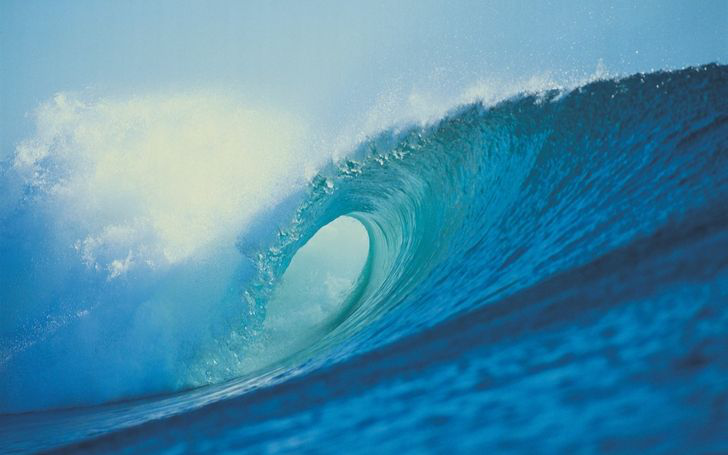

In [15]:
numpy2image(img_deep_dream)

In [16]:
#Пример как сделать forward до заданного слоя в resnet
net = models.resnet34(pretrained=True)

def my_forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)

    return x

in_img = torch.from_numpy(img_deep_dream).transpose(2,1).transpose(1,0).float()
in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True)
my_forward(net, in_img)

tensor([[[[0.0000e+00, 8.9237e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 2.9215e-01],
          [1.9169e+00, 4.7656e-01, 1.1417e+00,  ..., 5.6566e-01,
           6.2028e-01, 1.7250e+00],
          [9.7526e-01, 1.2995e-01, 4.7226e-01,  ..., 4.9965e-01,
           8.9651e-02, 1.3424e+00],
          ...,
          [0.0000e+00, 9.9716e-01, 2.3910e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.4182e+00, 0.0000e+00, 5.3830e-02,  ..., 0.0000e+00,
           2.3415e-01, 1.3651e+00],
          [3.3540e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 5.9797e-01]],

         [[5.9078e-01, 1.4236e-01, 1.6649e-02,  ..., 2.2343e-01,
           7.2810e-01, 3.4449e-01],
          [6.9620e-01, 0.0000e+00, 0.0000e+00,  ..., 1.3644e-01,
           7.9321e-01, 8.4640e-02],
          [6.3696e-01, 2.9475e-01, 8.8242e-02,  ..., 1.6617e-01,
           8.7641e-01, 1.3973e-01],
          ...,
          [7.2843e-01, 2.0056e-01, 1.5645e-03,  ..., 0.0000

In [17]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Задание 1
#### Применить всю сеть без fullconnected слоев (должны получить лица животных и что-то визуально внятное)

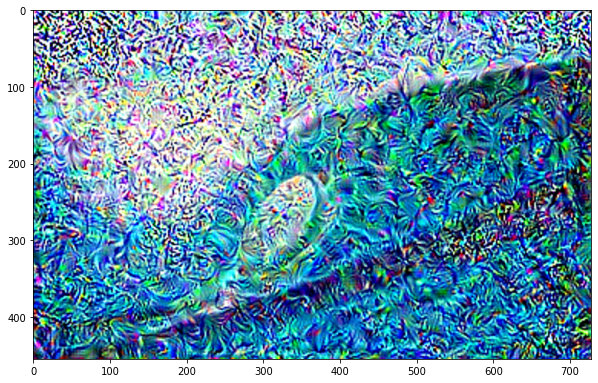

In [46]:
#Class to register a hook on the target layer (used to get the output channels of the layer)
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()
        
#Function to make gradients calculations from the output channels of the target layer 

def get_gradients(net_in, net, layer):     
    net_in = net_in.unsqueeze(0).cuda()
    net_in.requires_grad = True
    net.zero_grad()
    hook = Hook(layer)
    net_out = net(net_in)
    loss = hook.output[0].norm()
    loss.backward()
    return net_in.grad.data.squeeze()

#denormalization image transform
denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                   std = [ 1/0.229, 1/0.224, 1/0.225 ]),                 
                              transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                   std = [ 1., 1., 1. ]),                                                     
                              ])

#Function to run the dream.
def dream(image, net, layer, iterations, lr):
    image_tensor = transforms.ToTensor()(image)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])(image_tensor).cuda()
    for i in range(iterations):
        gradients = get_gradients(image_tensor, net, layer)
        image_tensor.data = image_tensor.data + lr * gradients.data

    img_out = image_tensor.detach().cpu()
    img_out = denorm(img_out)
    img_out_np = img_out.numpy().transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
    return img_out_pil


img = copy.deepcopy(img_deep_dream)
img = (255*img).astype('uint8')
img = Image.fromarray(img)
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))
layer = net.fc

img = dream(img, net.cuda(), layer, 1300, 50)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)

## Задание 2

#### Сделать deep dream по нижним слоям (после 1-2 конволюций) - должы закрасить некоторой текстурой картинку в итоге

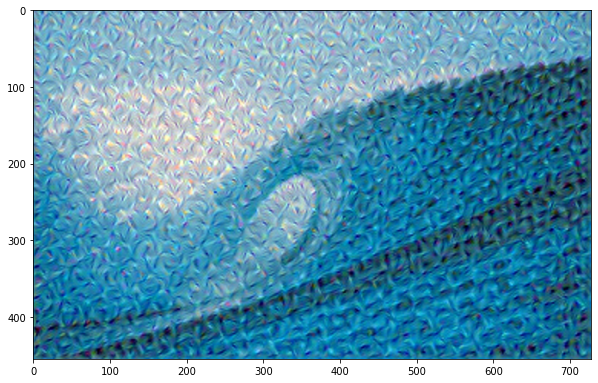

In [31]:
img = copy.deepcopy(img_deep_dream)
img = (255*img).astype('uint8')
img = Image.fromarray(img)
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))
layer = net.layer1

img = dream(img, net.cuda(), layer, 500, 1)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)


## Задание 3
#### Сделать deep dream по средним слоям - должы закрасить некоторыми осмысленными узорами картинку в итоге

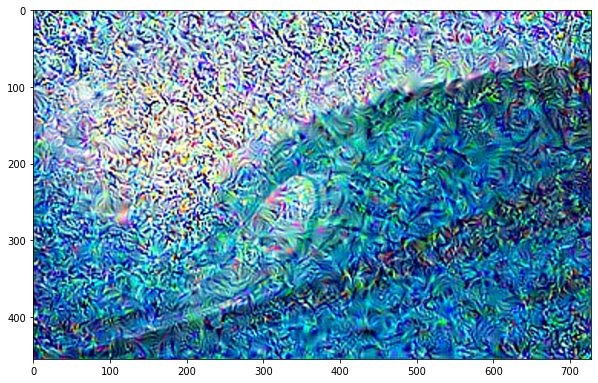

In [42]:
img = copy.deepcopy(img_deep_dream)
img = (255*img).astype('uint8')
img = Image.fromarray(img)
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
img = img.resize(new_size.astype(int))
layer = net.layer4

img = dream(img, net.cuda(), layer, 1000, 10)

img = img.resize(orig_size)
fig = plt.figure(figsize = (10 , 10))
plt.imshow(img)